# Motion Planning Part 2: differentiable motion planning

In this tutorial, we will build on the [first part](https://github.com/facebookresearch/theseus/blob/main/tutorials/04_motion_planning.ipynb) of the motion planning tutorial to illustrate how we can differentiate through a motion planner implemented using `Theseus`. In particular, we will show how to set up an imitation learning loop in `torch` to produce values to initialize the `TheseusLayer` so that it converges to a high quality trajectory faster. If you haven't already, we encourage you to review part 1 of the motion planning tutorial before proceeding with this one.

In [1]:
import random 

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.data
from IPython.display import clear_output

import theseus as th
import theseus.utils.examples as theg

%load_ext autoreload
%autoreload 2

torch.set_default_dtype(torch.double)

device = "cuda:0" if torch.cuda.is_available else "cpu"
torch.random.manual_seed(1)
random.seed(1)
np.random.seed(1)

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["font.size"] = 16

## 1. Initial setup

As in part 1 of the motion planning tutorial, the first step is to load a few planning problems from the dataset, and set up some constant quantities to use throughout the experiment. During this example, we will use a batch of 2 problems obtained from the loader.

In [2]:
dataset_dir = "data/motion_planning_2d"
num_prob = 2
dataset = theg.TrajectoryDataset(True, num_prob, dataset_dir, "tarpit")
data_loader = torch.utils.data.DataLoader(dataset, num_prob, shuffle=False)

batch = next(iter(data_loader))
map_size = batch["map_tensor"].shape[1]
trajectory_len = batch["expert_trajectory"].shape[2]
num_time_steps = trajectory_len - 1
map_size = batch["map_tensor"].shape[1]
safety_distance = 0.4
robot_radius = 0.4
total_time = 10.0
dt_val = total_time / num_time_steps
Qc_inv = [[1.0, 0.0], [0.0, 1.0]]
collision_w = 5.0
boundary_w = 100.0

Next we create the motion planner. Class `theg.MotionPlanner` stores a `TheseusLayer` constructed by following the steps described in part 1, and also provides some useful utility functions to retrieve trajectories from the current variables of the optimizer. 

In [3]:
planner = theg.MotionPlanner(
    map_size=map_size,
    epsilon_dist=safety_distance + robot_radius,
    total_time=total_time,
    collision_weight=collision_w,
    Qc_inv=Qc_inv,
    num_time_steps=num_time_steps,
    optim_method="levenberg_marquardt",
    max_optim_iters=2,
    step_size=0.3,
    device=device,
)

Since we are working with a single batch of data, we can initialize the input dictionary for the motion planner with some tensors that will be throughout this example. As a reminder, the input dictionary associates `th.Variable` names  in the `TheseusLayer` with tensor values for each of them.

In [4]:
start = batch["expert_trajectory"][:, :2, 0]
goal = batch["expert_trajectory"][:, :2, -1]
planner_inputs = {
    "sdf_origin": batch["sdf_origin"].to(device),
    "start": start.to(device),
    "goal": goal.to(device),
    "cell_size": batch["cell_size"].to(device),
    "sdf_data": batch["sdf_data"].to(device),
}

## 2. Imitation learning loop

### Overview

We consider the following imitation learning pipeline in this example (see Section 2.2):

* For some number of epochs:
    1. Generate initial variable values (i.e., trajectories) from `nn.Module` that uses map info as input.
    2. Plan trajectories using `TheseusLayer`, initializing optimization variables with the result of step 1.
    3. Compute a loss that encourages the output of step 2 to be a high quality trajectory that is close to an expert.
    4. Use backpropagation to update the parameters of the module in step 1.
    

### 2.1. A basic initial trajectory model

The following cell creates a basic model for generating initial trajectories. This model takes as input a one hot representation of the map's ID and generates a trajectory between the map's start and goal positions. The output is a dictionary with keys mapping to variable names, and values mapping to initial values (tensors) for each of them that represent the resulting trajectory.

<div class="alert alert-block alert-info">
<b>Note:</b> We don't include the model code to keep the focus on the learning part, but the interested reader can find it <a href="https://github.com/facebookresearch/theseus/blob/main/theseus/utils/examples/motion_planning/models.py">here</a>. This model takes advantage of the probabilistic interpretation of GPMP2 as a way to easily generate diverse smooth trajectories between the start and goal positions. The high level idea is as follows. The trajectory is generated by first producing a parabola whose focus is the middle point between start and goal, and whose distance between focus and vertex is the output of an MLP; this parabola makes it easier for the model to learn wide curves. Then, the model can add higher order curvatures to the trajectory by constructing a "sampled" trajectory around the parabola, using the probabilistic formulation of the motion planning problem. The sample in this case is the output of another MLP, which is used as a seed for "sampling" a trajectory around the parabola. The model then returns this sample as the initial trajectory to use.</div>

In [5]:
init_trajectory_model = theg.InitialTrajectoryModel(planner)
init_trajectory_model.to(device)
model_optimizer = torch.optim.Adam(init_trajectory_model.parameters(), lr=0.04) 

### 2.2. Learning loop

With the model in place, we can now put all of this together to differentiate through the motion planner, and find good initial trajectories for optimization on two maps. This loop essentially follows steps 1-4 from the overview subsection.

In [6]:
initial_trajectory_dicts = []
best_loss = float("inf")
losses = []
num_epochs = 100
best_epoch = None

# For speed considerations, we set the max number of optimizer iterations to a low number (2).
# This will also encourage the initial trajectory model to produce trajectories of higher quality.
planner.layer.optimizer.set_params(max_iterations=2)
for epoch in range(num_epochs):
    clear_output(wait=True)
    model_optimizer.zero_grad()
    
    # Step 1: Generate an initial trajectory by querying the model on the set of maps.
    initial_traj_dict = init_trajectory_model.forward(batch)
    # This updates the motion planner's input dictionary with the trajectories produced above.
    planner_inputs.update(initial_traj_dict)

    # Step 2: Optimize to improve on the initial trajectories produced by the model.
    planner.layer.forward(
        planner_inputs,
        optimizer_kwargs={
            "verbose": False,
            "damping": 0.1,
        }
    )        

    initial_trajectory_dicts.append(
        dict([(k, v.detach().clone()) for k, v in initial_traj_dict.items()]))

    # Step 3: Compute a loss evaluating the quality of the trajectories.
    # The loss consists of two terms. The first one encourages the final trajectory to 
    # match an expert trajectory available for this map (imitation_loss).
    # The second term uses the trajectory planner's total squared error, which also
    # encourages the trajectory to be smooth and avoid obstacles. We scale this term
    # by a small factor, since otherwise it would completely dominate over the
    # imitation loss.
    error_loss = planner.objective.error_squared_norm().mean() / planner.objective.dim()

    solution_trajectory = planner.get_trajectory()
    imitation_loss = F.mse_loss(
        batch["expert_trajectory"].to(device), solution_trajectory)
    loss = imitation_loss + 0.001 * error_loss
    
    # Step 4: Do backpropagation through the TheseusLayer and update the model parameters.
    loss.backward()
    model_optimizer.step()
    
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch
    losses.append(loss.item())
    print("------------------------------------")
    print(f"             Epoch {epoch}")
    print("------------------------------------")
    print(f"{'Imitation loss':20s}: {imitation_loss.item():.3f}")
    print(f"{'Error loss':20s}: {error_loss.item():.3f}")
    print(f"{'Total loss':20s}: {loss.item():.3f}")
    print("------------------------------------")
    print("------------------------------------")
    

------------------------------------
             Epoch 99
------------------------------------
Imitation loss      : 0.012
Error loss          : 0.134
Total loss          : 0.013
------------------------------------
------------------------------------


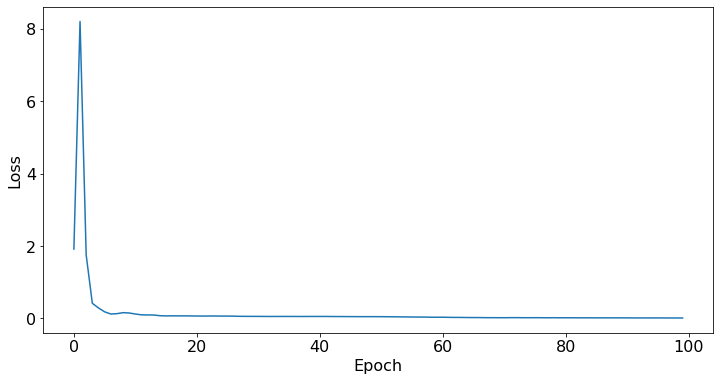

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## 3. Results

Let's now visualize the trajectories produced using the learned initializations, running the optimizer for a few more iterations. The following functions will be useful to plot the trajectories from the variable value dictionaries.

In [8]:
def get_trajectory(values_dict):
    trajectory = torch.empty(values_dict[f"pose_0"].shape[0], 4, trajectory_len, device=device)
    for i in range(trajectory_len):
        trajectory[:, :2, i] = values_dict[f"pose_{i}"]
        trajectory[:, 2:, i] = values_dict[f"vel_{i}"]
    return trajectory

def plot_trajectories(initial_traj_dict, solution_traj_dict, include_expert=False):
    initial_traj = get_trajectory(initial_traj_dict).cpu()
    sol_traj = get_trajectory(solution_traj_dict).detach().clone().cpu()

    sdf = th.eb.SignedDistanceField2D(
        th.Point2(batch["sdf_origin"]),
        th.Variable(batch["cell_size"]),
        th.Variable(batch["sdf_data"]),
    )
    trajectories = [initial_traj, sol_traj]
    if include_expert:
        trajectories.append(batch["expert_trajectory"])
    figs = theg.generate_trajectory_figs(
        batch["map_tensor"], 
        sdf, 
        trajectories,
        robot_radius=0.4, 
        labels=["initial trajectory", "solution trajectory", "expert"], 
        fig_idx_robot=1,
        figsize=(6, 6)
    )
    for fig in figs:
        fig.show()

### 3.1. Trajectories initialized from straight lines

As reference, below we show the quality of trajectories obtained after 10 optimizer iterations when initialized from a straight line. As the plots show, the trajectories produced from a straight line are of bad quality; more than 10 iterations are neeed to produce good quality trajectories (in part 1, we used 50). 

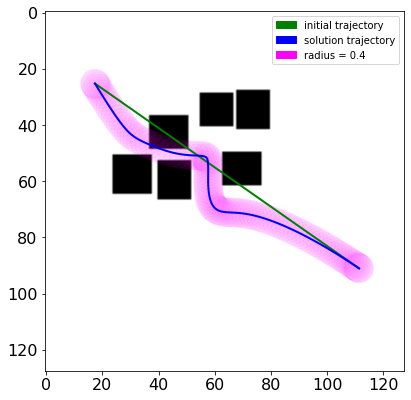

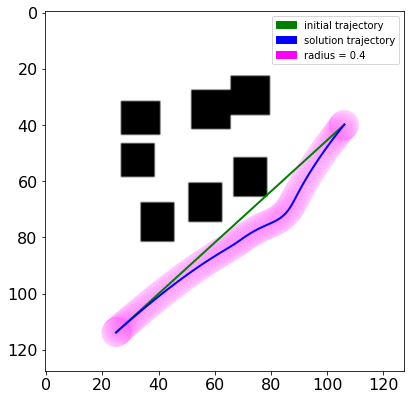

In [9]:
straight_traj_dict = planner.get_variable_values_from_straight_line(
    planner_inputs["start"], planner_inputs["goal"])

planner_inputs.update(straight_traj_dict)
planner.layer.optimizer.set_params(max_iterations=10)
solution_dict, info = planner.layer.forward(
    planner_inputs,
    optimizer_kwargs={
        "verbose": False,
        "damping": 0.1,
    }
)
plot_trajectories(straight_traj_dict, solution_dict)

### 3.2 Learned initial trajectories

On the other hand, with learned initial trajectories the plots below show 10 iterations is enough to produce smooth trajectories that avoid all obstacles, illustrating the potential of differentiating through the trajectories planner.trj

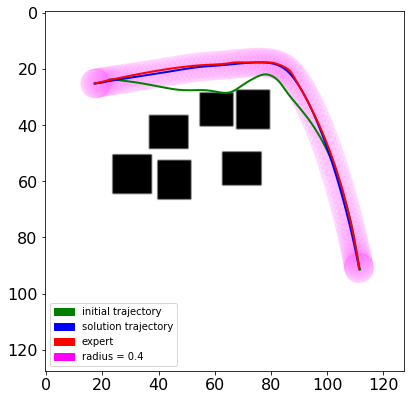

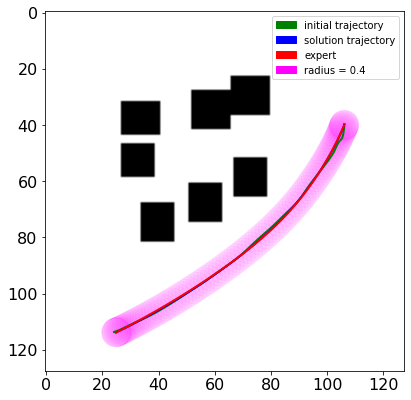

In [10]:
planner_inputs.update(initial_trajectory_dicts[best_epoch])
planner.layer.optimizer.set_params(max_iterations=10)
solution_dict, info = planner.layer.forward(
    planner_inputs,
    optimizer_kwargs={
        "verbose": False,
        "damping": 0.1,
    }
)
plot_trajectories(
    initial_trajectory_dicts[best_epoch], solution_dict, include_expert=True)